# シンプルなディープラーニング

PyTorchを使って簡単なディープラーニングを実装します。  
今回は、ディープラーニングにより手書き文字の認識を行います。

## 手書き文字画像の確認

scikit-learnから、手書き数字の画像データを読み込んで表示します。  

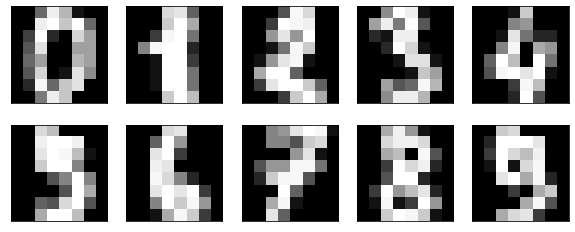

データの形状: (1797, 64)
ラベル: [0 1 2 3 4 5 6 7 8 9]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()

n_img = 10  # 表示する画像の数
plt.figure(figsize=(10, 4))
for i in range(n_img):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)  # 軸を非表示に
    ax.get_yaxis().set_visible(False)
plt.show()

print("データの形状:", digits_data.data.shape)
print("ラベル:", digits_data.target[:n_img])

## データを訓練用とテスト用に分割

In [6]:
import torch
from sklearn.model_selection import train_test_split

digit_images = digits_data.data
labels = digits_data.target
x_train, x_test, t_train, t_test = train_test_split(digit_images, labels)  # 25%がテスト用

# Tensorに変換
x_train = torch.tensor(x_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.int64) 
x_test = torch.tensor(x_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.int64) 

In [10]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

torch.Size([1347, 64])
torch.Size([1347])
torch.Size([450, 64])
torch.Size([450])


## モデルの構築

In [29]:
from torch import nn
from torchinfo import summary

net = nn.Sequential(
    nn.Linear(64, 32),  # 全結合層
    nn.ReLU(),          # ReLU
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)
print(net)
print(65 * 32)  # bias 項があるので 64 + 1
print(33 * 16)
print(17 * 10)
summary(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)
2080
528
170


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            2,080
├─ReLU: 1-2                              --
├─Linear: 1-3                            528
├─ReLU: 1-4                              --
├─Linear: 1-5                            170
Total params: 2,778
Trainable params: 2,778
Non-trainable params: 0

## 学習
モデルを訓練します。  
今回は、損失関数に交差エントロピー誤差を、最適化アルゴリズムにSGD（確率的勾配降下法）を設定します。  
順伝播は訓練データ、テストデータ両者で行い誤差を計算します。  
逆伝播を行うのは、訓練データのみです。  


In [30]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 学習率は0.01

# 損失のログ
record_loss_train = []
record_loss_test = []

# 1000エポック学習
for i in range(1000):

    # 勾配を0に
    optimizer.zero_grad()  # これがないと勾配が蓄積される。
    
    # 順伝播
    y_train = net(x_train)
    y_test = net(x_test)
    
    # 誤差を求める
    loss_train = loss_fnc(y_train, t_train)  # スカラーの tensor が帰ってくる。
    loss_test = loss_fnc(y_test, t_test)
    record_loss_train.append(loss_train.item())  # one element tensor なので .item() で中身を取り出す。
    record_loss_test.append(loss_test.item())  # one element 出ない場合は、.item() 使えない。

    # 逆伝播（勾配を求める）
    loss_train.backward()
    
    # パラメータの更新
    optimizer.step()

    if i%100 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train.item(), "Loss_Test:", loss_test.item())

Epoch: 0 Loss_Train: 3.005112409591675 Loss_Test: 3.000723123550415
Epoch: 100 Loss_Train: 0.8588687777519226 Loss_Test: 0.9311943650245667
Epoch: 200 Loss_Train: 0.4098927080631256 Loss_Test: 0.4811508059501648
Epoch: 300 Loss_Train: 0.259036660194397 Loss_Test: 0.31260043382644653
Epoch: 400 Loss_Train: 0.1878502368927002 Loss_Test: 0.2322625070810318
Epoch: 500 Loss_Train: 0.1482071578502655 Loss_Test: 0.19233962893486023
Epoch: 600 Loss_Train: 0.12264776974916458 Loss_Test: 0.16982783377170563
Epoch: 700 Loss_Train: 0.10425888001918793 Loss_Test: 0.15555207431316376
Epoch: 800 Loss_Train: 0.09023527801036835 Loss_Test: 0.14566180109977722
Epoch: 900 Loss_Train: 0.079070545732975 Loss_Test: 0.13846455514431


## 誤差の推移

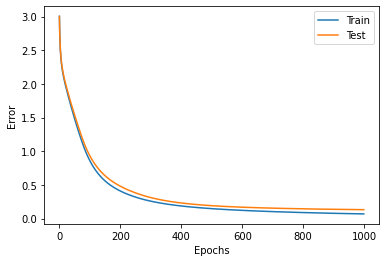

In [31]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率

In [41]:
y_test = net(x_test)
print(y_test.shape)
print(y_test.argmax(1).shape)
count = (y_test.argmax(1) == t_test).sum().item()  # one element tensor なので、.item()
print("正解率:", str(count/len(y_test)*100) + "%")

torch.Size([450, 10])
torch.Size([450])
正解率: 95.55555555555556%


## 訓練済みのモデルを使った予測

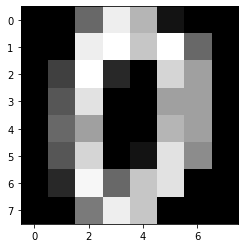

正解: 0 予測結果: 0


In [42]:
img_id = 0
x_pred = digit_images[img_id]
image = x_pred.reshape(8, 8)
plt.imshow(image, cmap="Greys_r")
plt.show()

x_pred = torch.tensor(x_pred, dtype=torch.float32)
y_pred = net(x_pred)
print("正解:", labels[img_id], "予測結果:", y_pred.argmax().item())